# DCG Tutorial

!mkdir models

This notebook contains a complete example of use for the ```dcg``` library, from graph definition and training to causal query estimation.

Prerequisites:

* Install all three libraries (```torch_misc```, ```flow```, ```dcg```) as stated in the root folder README.md file.
* Generate the synthetic dataset by executing the notebook found inside the data/ folder.

In [1]:
import os.path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

# For reproducibility
np.random.seed(123)
torch.random.manual_seed(1234)

# Determine the torch device first
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In this tutorial we will operate with a synthetic dataset describing salaries and associated variables.

First, we load the dataset and describe the underlying graph structure, that can be found in the data/definition.txt file.

In [2]:
# Load the dataset
df_train = pd.read_csv(os.path.join('data', 'train.csv'))
df_test = pd.read_csv(os.path.join('data', 'test.csv'))

df_train.head()

,gender,field_0,field_1,field_2,age,education,seniority,salary
0,False,0,0,1,28.167546,0.278197,0.635367,22915.529781
1,True,1,0,0,34.301064,0.419442,1.497411,36487.569950
2,False,0,1,0,29.023078,0.165927,0.979590,25591.650248
3,False,0,1,0,23.130233,0.488480,1.226342,30734.659278
4,True,0,1,0,36.458887,0.487854,1.508292,31897.254739


The Causal Graph underlying this dataset is the following:

<img src='images/salary_graph.png' width=50% />

Note the latent confounder between gender and age, which we use to model a plausible form of selection bias resulting
from parents who leave work to take care of their children, with more incidence on women. This process biases the data so that people who are still working while being older (hence more likely to have children) are mostly men. We will call the latent confounder modelling this form of selection bias "stay at home". 

We need to pass this graph structure into the DCG library, so we will define now the graph definition format. The data/definition.txt file contains this definition.

In [3]:
with open(os.path.join('data', 'definition.txt')) as f:
    definition = f.read()
    
print(definition.strip())

stay_at_home lat 1
gender bern 1 stay_at_home
field cat 3 gender
age cont 1 stay_at_home
education cont 1 age
seniority cont 1 age education gender field
salary cont 1 education seniority field


Graph definitions in this library are declared as a list of variables, one per line, with each line containing:

* Variable name (any name not containing whitespaces).
* DCU type alias. We define an alias for each type of Deep Causal Unit we want to use. In this example, ```lat``` for a latent DCU, ```bern``` for Bernoulli Distributional Causal Nodes (DCN), ```cat``` for Categorical DCNs, ```cont``` for continuous variables, that we will model with Normalizing Causal Flows (NCF). Afterwards, we will assign each alias to the actual DCU types.
* Dimension: an integer defining the dimension of the variable. Bernoulli (binary) variables have dimension 1, modelled with a binary variable; Categorical DCNs have as many dimensions as levels, modelled with a one-hot encoding.
* List of parent variables for that node (whitespace separated); for example, salary has as parents education, seniority and field, so we list them at the end of the salary line.

Note that latent confounders (the dashed bidirectional line in the graph) are described as additional variables, with a latent DCU as type, that act as parents of both confounded variables.

The order in which we list variables matters: it is the order in which they appear in the input tensors that we will pass to the graph. In this case, the same order as the loaded DataFrame. Latent variables, since they are not measured, do not count in this order and can appear at any position.

## Data Preprocessing

Before we move on to the DCG creation and training, we need to transform our dataset into a Pytorch Tensor.

In [4]:
Xtrain = torch.Tensor(df_train.values.astype(float))
Xtest = torch.Tensor(df_test.values.astype(float))

# We will also split the training dataset in train and validation, 80-20% respectively.
n = int(len(Xtrain) * .8)

Xtrain, Xval = Xtrain[:n], Xtrain[n:]

## DCG Creation

Now that we have the data and the graph definition, we can create the DCG model.

For a complete DCG model, we need three things:

* A flow creation function, that will be used by the NCF implementation to define the Transformer architecture.
* A network creation function, that will be used to create the shared conditioner for the graph.
* The parsed graph definition: we need to link DCU aliases to their implementations.

The exact choice of architecture both for the Conditioner network and the Flow Transformer depends on the dataset. Sample size, distribution complexity, domain, etc., all affect in this decision.

### Flow Definition

Let's take a detour to describe Normalizing Flows and how to define them with the ```flow``` library.

We start with a noise signal $U$, for which we impose a certain *prior* distribution $P(U)$, usually the Normal Distribution: $U \sim \mathcal{N}(\mathbb{0}_k, \mathbb{1}_k)$.

A Normalizing Flow (NF) is an **invertible** function $f$ that transforms the target distribution $X$ into $U$. Then: $U = f(X); X = f^{-1}(U)$. A *Conditional* Normalizing Flow transforms the conditioned distribution $P(X \mid Z)$, with $Z$ the conditioning variable, into $U$. We are specially interested in this latter case, as NCFs model distributions $(X \mid Pa_X)$ for each node $X$, given its parents' values $Pa_X$.

Following the Transformer-Conditioner framework, a Normalizing Flow (NF) consists on a function $g_\Theta$ that transforms $X$ into $U$, with this function depending on a set of parameters $\Theta$, which are computed by a Conditioner $h$. This Conditioner function may depend on a set of conditioning values $Z$, but also on some dimensions of $x$ (*e.g.*, an autoregressive Conditioner computes $\theta_i$ for dimension $x_i$ given the values for every previous dimension $x_j, \forall j < i$). Then, the overall flow $f$ is: $f = g_h$. 

One thing to note is that we can stack several NFs together by composition; given a sequence of flow transformations $(f_i)_{i=1..I}$, the composed flow is $f := f_I \circ \dots \circ f_1$. What's more, we can define each of these flows simply as their transformer functions, and let a single Conditioner output all parameters $\Theta := (\Theta_1, \dots, \Theta_I)$, with each $\Theta_i$ affecting the corresponding transformer $g_{\Theta_i}$.

For one-dimensional continuous variables, as it is often the case in Causal Graphs, it is enough to define a shared single Conditioner as described here. For multi-dimensional variables, this is still possible, as long as the employed transformers do not shuffle the dimensions of the to-be-transformed tensor $x \sim X$, so as to not break the autoregressive structure of the conditioner.

In this tutorial, we will only cover the use case of single-dimensional variables with a shared conditioner. The conditioner will be created by the ```dcg``` Shared Conditioner directly, so we just need to focus on the Transformer architecture.

In [5]:
# Import from flow to create the flow Transformer for each NCF
from flow.flow import Sequential as SequentialFlow, inv_flow
from flow.transformer import Affine, RQ_Spline
from flow.modules import Scaler, Normalizer, Softplus
from flow.prior import Normal as NormalPrior

# Extra utilities
from functools import partial

In order to use our flows with the ```dcg``` library, we define them in functions f(dim, cond_dim=0), that create and return the desired flow. ```dim``` is the dimension of the variable to model, ```cond_dim``` is the dimension of the conditioning tensor (the sum of dimensions of the node's parents). Since we are only creating the Flow-Transformers, we can ignore the cond_dim parameter in this case, as it only affects the Conditioner architecture.

We can define a sequence of flows (either complete Conditioner-Transformer flows, or just Transformers) with flow.flow.Sequential, that we imported above as SequentialFlow. We pass our sequence of flows as arguments of its constructor and end it with two keyword arguments: dim, to inform the dimension of each of these blocks, and prior, to specify the prior distribution of $U$.

The flow is defined to transform from $X$ to $U$, so we need to take into account the domain of $X$ before we carry any additional steps. Since all our continuous variables are non-negative, let's create a flow that works on this domain.

In [6]:
# Flow creation function
def flow_f(dim, cond_dim=0):
    # cond_dim is ignored in this case, as we are creating a Transformer-only flow; 
    # its parameters come from the graph's Shared Conditioner.
    
    # The flow library creates flows by transforming the dataset values 
    # back to the flow's prior, in this case a Normal.
    # Since every continuous variable in this dataset is positive,
    # we can use the inverse (inv_flow) of a Softplus to transform from non-negatives to all reals.
    # We'll precede it with a scaler to reduce its scale.
    
    # Afterwards, we use a Normalizer to transform to mean 0, std 1,
    # and then apply 5 blocks of Spline transformers (8 splits in the (-3, 3) interval)
    # and an affine flow (sigma * x + mu) after each spline.
    
    # We end it by defining the flow's prior (a Normal)
    # and the dimension of the variable.
    
    return SequentialFlow(
        Scaler, # adjusts the scale without touching the main
        inv_flow(Softplus), # remove this if your variable is not positive
        Normalizer,
        *sum((
            [
                partial(RQ_Spline, K=8, A=-3., B=3.),
                Affine
            ]
            for _ in range(5)
        ), []),
        
        prior=NormalPrior,
        dim=dim
    )

Note that we pass **classes** to Sequential, **not instances** of them; that is why we need to use ```partial(RQ_Spline, ...)``` to specify K, A and B.

### Conditioner Network

The Conditioner Network can be anything; it just needs to take input_dim dimensions as input and return output_dim dimensions as output. We use the init parameter to specify initialization values for the last bias in the feed-forward network.

In [7]:
from torch import nn

# Network creation function
def net_f(input_dim, output_dim, init=None):
    # input_dim: total dimensionality of measured and unmeasured (latent) variables. 
    # output_dim: total dimensionality of all parameters computed by the shared conditioner.
    # init: tensor with the initialization values for each resulting parameter.
    
    net = nn.Sequential(
        nn.BatchNorm1d(input_dim, affine=False),
        nn.Linear(input_dim, 256),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(128, output_dim)
    )
    
    if init is not None:
        net[-1].bias.data = init
    
    return net

### Parse Definition and Graph Creation

In [8]:
# Import CausalGraph
from dcg.graph import CausalGraph

# Import every DCU specification that we want to use
from dcg.distributional.discrete import Bernoulli, Categorical
from dcg.flow import NCF
from dcg.latents import Normal as Latent # for latents, a Normal distribution is enough

# Import the training module
from dcg.training import * # this includes: train, loss_f, plot_losses, test_nll, data_loader, TensorDataset

In [9]:
# Parse graph definition
parsed_definition = CausalGraph.parse_definition(
    definition,
    
    # List every alias definition here
    lat=Latent,
    bern=Bernoulli,
    cat=Categorical,
    cont=partial(NCF, flow_f=flow_f) # we need to pass the flow structure here for the NCF class
)

In [10]:
# Now that we have everything ready, we can create the DCG model:
graph = CausalGraph.from_definition(
    parsed_definition,
    net_f=net_f # here we pass the Shared Conditioner network creator
)

# Never forget to to use the warm_start operation, passing the training dataset,
# and to send the graph module to the appropriate device (cuda).
graph = graph.warm_start(Xtrain).to(device)

graph

CausalGraph(
  (nodes): ModuleList(
    (0): <Normal: stay_at_home>
    (1): <Bernoulli: gender>
    (2): <Categorical: field>
    (3): <NCF: age>
    (4): <NCF: education>
    (5): <NCF: seniority>
    (6): <NCF: salary>
  )
  (net): AdjacencyMaskedNet(
    (net): Sequential(
      (0): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      (1): Linear(in_features=9, out_features=256, bias=True)
      (2): ReLU()
      (3): Dropout(p=0.5, inplace=False)
      (4): Linear(in_features=256, out_features=128, bias=True)
      (5): ReLU()
      (6): Dropout(p=0.5, inplace=False)
      (7): Linear(in_features=128, out_features=504, bias=True)
    )
  )
)

## DCG Training

Let's train the DCG. We will use several utility functions from dcg.training.

```train```: trains a graph. 

* Requires:
    * graph: graph to train.
    * train_loader: data loader for the training set.
    * val_loader: data loader for the validation set.
    * loss_f: loss function(module, batch) to train. 
        Receives the module and a batch to compute the loss of.
        Returns a Tensor with the loss for each sample in the batch (not the aggregation).
        dcg.training.loss_f is a function that returns the training loss for a DCG graph automatically.
* Optional parameters:
    * optimizer: torch.optim.Optimizer to use. Defaults to AdamW.
    * optimizer_kwargs: keyword arguments to pass to the optimizer (e.g., lr, weight_decay)
    * scheduler: torch.optim.lr_scheduler scheduler. Defaults to None.
    * scheduler_kwargs: kwargs to pass to the scheduler.
    * n_epochs: max number of epochs to run training. None by default.
    * patience: number of epochs without gain in validation before we early stop training. None by default.
    * gradient_clipping: clips the magnitude of the gradient. None by default.
    * callback: callback function to call at every step of training. Check the documentation for more details.
    * use_tqdm: use tqdm to track training progress. 
* Returns:
    * train_losses: list of tuples (epoch, loss) with the average training loss on each epoch. 
    * val_losses: list of tuples (epoch, loss) with the average validation loss on each epoch.
        
We will also use the ```dcg.training.plot_losses``` function to plot the progress of losses throughout training.
We just need to pass the result of train to this function, either: ```train_losses, val_losses = train(...); plot_losses(train_losses, val_losses)``` or ```plot_losses(*train(...))```.

NOTE: You can use your own training procedure if you so desire. ```graph.nll``` returns the negative log-likelihood of every inputted sample (*e.g.*, ```graph.nll(X)```), so you can use its mean(0) for your training loss directly.

In [11]:
# We add this toggle here to avoid training the graph if it's already been trained.
# Set TRAIN to False if you have already trained it, so as to load it instead.
TRAIN = False

In [12]:
path = os.path.join('models', 'graph.pt')

if TRAIN:
    train_losses, val_losses = train(
        graph,
        # dcg.training.data_loader returns a data loader for the given torch Dataset
        data_loader(TensorDataset(Xtrain), batch_size=256, drop_last=True), 
        data_loader(TensorDataset(Xval), batch_size=256, drop_last=False),
        loss_f=loss_f(ex_n=100),
        optimizer_kwargs=dict(lr=1e-3, weight_decay=1e-2),
        patience=100,
    )

    plot_losses(train_losses, val_losses)
    
    torch.save(graph.state_dict(), path)
else:
    graph.load_state_dict(torch.load(path))
    graph.eval()

We can use the test loglk (the bigger, the better) as a measure of fitness to the dataset's distribution:

In [13]:
test_loglk(graph, Xtest, batch_size=216)

-13.211454

Let's inspect the learned distribution.

We will generate an observational sample from the dataset, whose distribution should be similar to the one that generated the dataset.

This can be done with the ```graph.sample``` method; just pass the number of samples to create.

In [14]:
with torch.no_grad():
    sample = graph.sample(len(df_train)) # returns a Tensor with every observable variable
    # Let's create a DataFrame from this Tensor for convenience
    sample = pd.DataFrame(sample.cpu().numpy(), columns=df_train.columns)
    
sample.head()

,gender,field_0,field_1,field_2,age,education,seniority,salary
0,0.0,0.0,0.0,1.0,25.920527,0.142753,0.742796,22346.787109
1,0.0,0.0,0.0,1.0,31.654617,0.531069,0.960962,23978.066406
2,1.0,1.0,0.0,0.0,23.870590,0.090502,1.102813,26955.271484
3,0.0,0.0,1.0,0.0,28.238104,0.463145,1.859903,33621.906250
4,0.0,0.0,0.0,1.0,37.107235,0.731848,0.876773,26326.042969


Here we inspect each discrete variable's marginal:

In [15]:
pd.DataFrame(dict(real=df_train.loc[:, :'field_2'].mean(0), dcg=sample.loc[:, :'field_2'].mean(0)))

,real,dcg
gender,0.456857,0.374422
field_0,0.473421,0.365755
field_1,0.262519,0.198190
field_2,0.264060,0.436055


And the histograms and scatterplots for continuous variables:

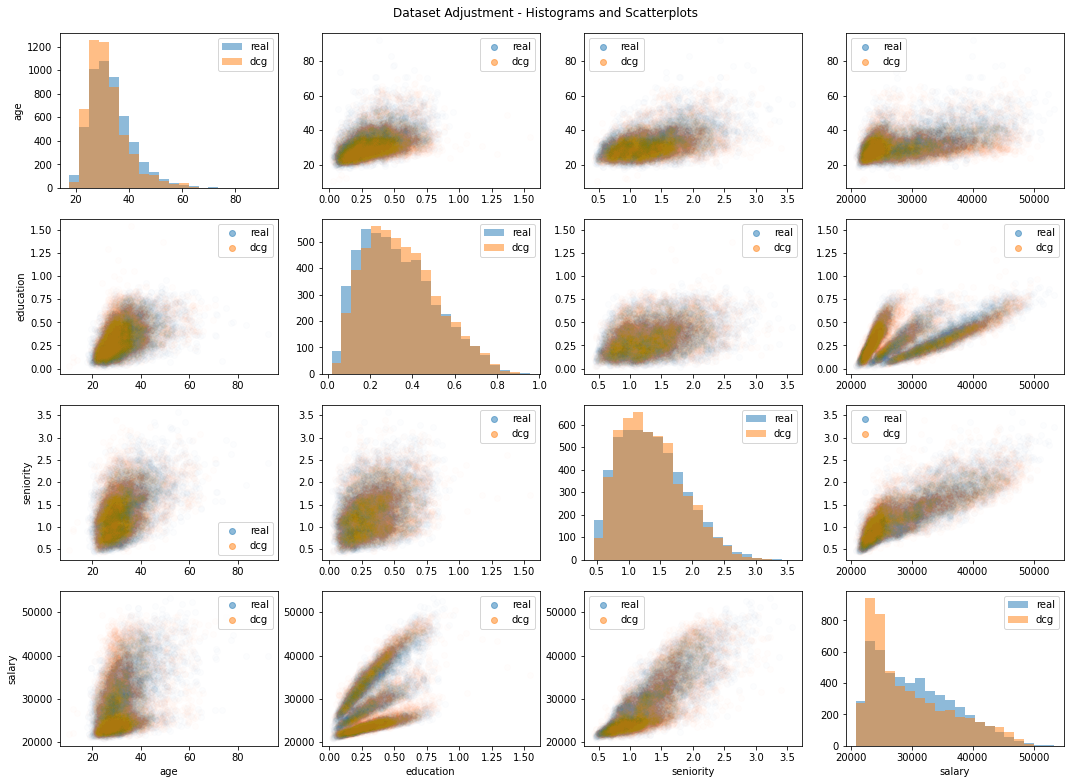

In [16]:
df_real, df_sample = (df.loc[:, 'age':] for df in (df_train, sample))

fig, axes_mat = plt.subplots(4, 4, figsize=(4.5 * 4, 3 * 4))
for i, axes in enumerate(axes_mat):
    for j, ax in enumerate(axes):
        coli_real = df_real.iloc[:, i]
        coli_sample = df_sample.iloc[:, i]
        
        if i == j:
            _, bins, _ = ax.hist(coli_real, bins=20, alpha=.5, label='real')
            ax.hist(coli_sample, bins=bins, alpha=.5, label='dcg')
            ax.legend()
        else:
            colj_real = df_real.iloc[:, j]
            colj_sample = df_sample.iloc[:, j]
            
            ax.scatter(colj_real, coli_real, alpha=.01)
            ax.scatter(colj_sample, coli_sample, alpha=.01)
            
            # Plot legend
            # Since alpha was low, we need to plot some points out of bounds
            xlim, ylim = ax.get_xlim(), ax.get_ylim()
            ax.scatter(xlim[0]-1000, ylim[0]-1000, c='C0', alpha=.5, label='real')
            ax.scatter(xlim[0]-1000, ylim[0]-1000, c='C1', alpha=.5, label='dcg')
            ax.set_xlim(xlim); ax.set_ylim(ylim)
            ax.legend()

for ax, col in zip(axes_mat[-1], df_real.columns):
    ax.set_xlabel(col)

for ax, col in zip(axes_mat[:, 0], df_real.columns):
    ax.set_ylabel(col)

fig.subplots_adjust(top=0.95)
plt.suptitle('Dataset Adjustment - Histograms and Scatterplots')
plt.savefig('plots/adjustment.pdf');

The adjustment to the dataset distribution is not perfect (it never will) but we must strive to get as close as possible, by tweaking the conditioner net, flow architecture and the training parameters. Graph training is an iterative process, necessary before we carry out any estimations.

# Causal Query Estimation

Now that we have a trained model, we can estimate any queries we want, **as long as they are identifiable**. 

We will show what methods are implemented in the ```dcg``` library and how we can use them to estimate our queries.

## DCG Methods

Here we describe the main methods we will use throughout the next sections. 

* ```sample(self, n=1, target_node=None, interventions=None, return_all=False)```: allows us to generate ```n``` samples from the distribution. If we just want to obtain samples from a certain node, pass the node's name to ```target_node```. If we want to sample from the intervened distribution, we can pass any desired interventions to the ```interventions``` parameter, as a dictionary. The method will return a tensor with all variables or only the requested target variable. If ```return_all``` is True, it will also return a dictionary with each node's value (including latents and exogenous noise signals).
* ```loglk(self, x, target_node=None, interventions=None, cond=None, ex_n=100)```: computes the log-likelihood of samples x: $\log P(x)$. If we pass a ```target_node```, it will just compute $\log P(Y)$ where $Y$ is the target_node. If we pass a conditioning dictionary $Z$ = { node: value } with the ```cond``` parameter, it returns $\log P(x \mid Z)$. Finally, we can pass any ```interventions``` we desire, if we want to compute loglks in the intervened model. ```ex_n``` determines how many samples can be generated for any missing variable needed in the computation.
* ```cond_exp(self, x, f=None, ex_n=100)```: computes the conditional expectation $\mathbb{E}_{V \mid Z}\big[f(V)\big]$, where $V$ are all observable variables in the graph, ```f``` is the provided function (or the identity if None), and $Z$ are the conditioning terms, defined by the dictionary ```x``` = { node: value }. If we need to compute additional samples, ```ex_n``` determines how many will be sampled. 
* ```counterfactual(self, x, target_node=None, interventions=None, ex_n=100, f=None, agg=True)```: computes the counterfactual expectation $\mathbb{E}\big[ f(V_t) \mid x \big]$ where $x$ are the factual, observed variables (either a dict or a tensor with all measured variables), $f$ is a function that applies to the counterfactual variables (identity if ```f``` is None) and $t$ are the provided ```interventions```. If ```target_node``` is provided, the method just computes the counterfactual target_node and passes it to $f$, instead of every other variable. ```ex_n``` determines how many missing/abducted samples will be generated. Finally, if ```agg``` is False, the method doesn't compute the aggregated result, but returns the counterfactual samples along with the associated *unnormalized* weights (use softmax to normalize them), indexing terms, etc., that can be used to perform other kinds of queries (counterfactual sampling, for example). 

Most of these functions accept different formatting for its inputs. Values can be passed either as a Tensor (in which case it is a matrix with every measured variable in the graph, in the order specified in the definition) or as a dict { node: value }. Note that you can always pass dicts; full Tensor matrices are only accepted in the loglk x parameter or the counterfactual x parameter.

For a dict input, its keys can either be node names (str) or the actual nodes in the graph (accessed with ```graph[name]```); its values can either be single values (bools, ints, floats), numpy arrays for single dimensional variables or matrices for multi-dimensional variables, or torch Tensors (in the appropriate device). 

We will now exemplify these methods while computing causal queries of interest. 

## Observational and Interventional Queries

Let's first investigate the causal effect of every variable $X$ on salary $Y$, $\mathbb{E}\big[Y \mid do(X=x)\big]$ and compare it with the conditional query $\mathbb{E}\big[Y \mid X\big]$. $X$ will be either a Bernoulli (binary) variable, a Categorical variable, or a continuous variable; the procedure will essentially be the same.

Note that all of these queries are identifiable (the causal effect can be computed through the back-door formula), so it is licit to use DCGs to compute their estimations. **Always check for identifiability before estimation.**

In [17]:
N = 1000 # number of samples to create

### Gender Effect on Salary

In [18]:
# Interventional effect
with torch.no_grad():
    sample = graph.sample(N * 2, target_node='salary', interventions=dict(gender=[True, False]))
    # We asked for 2N samples, N for gender=True (male), N for gender=False (female).
    # We aggregate each one separately and transform the cuda tensor back to a numpy array
    sample = sample.view(N, 2).mean(0).cpu().numpy()
    
sample

array([35518.33, 26393.65], dtype=float32)

In [19]:
# Observational effect (conditional)
with torch.no_grad():
    # We observe/condition on gender, and want the expectation of salary. 
    # We pass the conditioning terms first, then specify f, from which we compute E[f(V)].
    # If we pass a str, f filters V to the specified node.
    obs = graph.cond_exp(dict(gender=[True, False]), f='salary', ex_n=N)
    obs = obs.cpu().numpy()
    
obs

array([[36654.55 ],
       [26045.605]], dtype=float32)

### Field Effect on Salary

Field is a 3-level Categorical variable, modelled as three binary columns, one per level.

As intervention, we can pass the identity matrix with dimension 3, so we have one (1, 0, 0), (0, 1, 0), (0, 0, 1) as values. We use np.eye to create it.

In [20]:
# Interventional effect
with torch.no_grad():
    sample = graph.sample(N * 3, target_node='salary', interventions=dict(field=np.eye(3)))
    sample = sample.view(N, 3).mean(0).cpu().numpy()
    
sample

array([35704.383, 29468.781, 24559.17 ], dtype=float32)

In [21]:
# Observational effect (conditional)
with torch.no_grad():
    obs = graph.cond_exp(dict(field=np.eye(3)), f='salary', ex_n=N // 3) # we use less values for ex_n to fit in GPU memory
    obs = obs.cpu().numpy()
    
obs

array([[35821.527],
       [29679.129],
       [24682.807]], dtype=float32)

### Continuous Variables

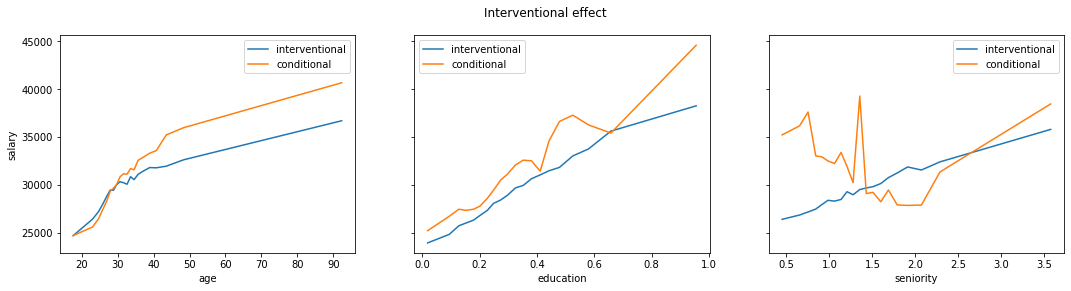

In [22]:
K = 20 # we will generate K values for the intervening variable and plot the curve

fig, axes = plt.subplots(1, 3, figsize=(6 * 3, 4), sharey=True)

for ax, v in zip(axes, ['age', 'education', 'seniority']):
    intv = df_train[v].quantile(np.linspace(0, 1, K)).values # generate quantiles from 0 to 1

    with torch.no_grad():
        # Interventional effect
        intv_sample = graph.sample(N * K, target_node='salary', interventions={v: intv})
        # sample is a Tensor with N * 20 samples, we are interested in the average effect for each value
        intv_sample = intv_sample.view(N, K).mean(0).cpu().numpy()
        
        # Conditional effect
        # graph.cond_exp needs more memory than graph.sample
        # so ex_n=N requires a lot of memory if we pass every generated quantile.
        # We compute them one by one so as to save memory during the computation.
        cond_sample = np.array([
            graph.cond_exp({v: x}, 'salary', ex_n=N).item()
            for x in intv
        ])
    
    ax.plot(intv, intv_sample, label='interventional')
    ax.plot(intv, cond_sample, label='conditional')
    ax.legend()
    ax.set_xlabel(v)

axes[0].set_ylabel('salary')
fig.suptitle('Interventional effect')
plt.savefig('plots/intv.pdf');

## Likelihood Queries

We can compute likelihood queries, observational or interventional. We will plot two histograms along with the computed densities, and see how they fit each other.

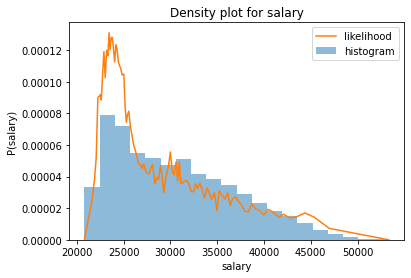

In [23]:
K = 100

x = df_train.salary
qs = df_train.salary.quantile(np.linspace(0, 1, K)).values
with torch.no_grad():
    loglk = graph.loglk(dict(salary=qs), target_node='salary', ex_n=1000)
    lk = torch.exp(loglk).cpu().numpy()
    
plt.hist(x, bins=20, alpha=.5, density=True, label='histogram')
plt.plot(qs, lk, label='likelihood')
plt.xlabel('salary')
plt.ylabel('P(salary)')
plt.legend()
plt.title('Density plot for salary')
plt.savefig('plots/density1.pdf')

We can also inspect conditional likelihoods:

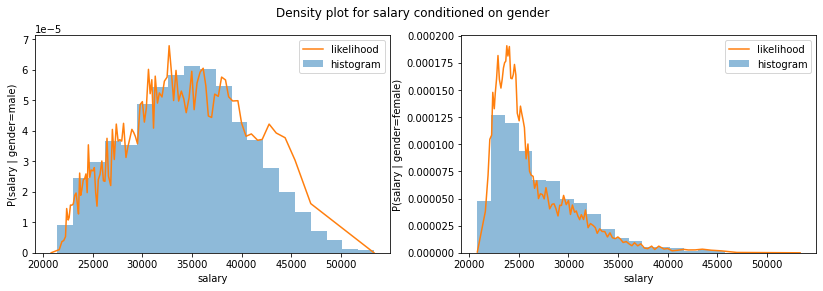

In [24]:
K = 100

fig, axes = plt.subplots(1, 2, figsize=(7 * 2, 4))

for ax, v in zip(axes, [True, False]):
    if v: cond = df_train.gender
    else: cond = ~df_train.gender
    
    x = df_train.salary[cond] # salary conditioned on gender
    qs = df_train.salary.quantile(np.linspace(0, 1, K)).values # we compute the loglk of values unconditionally
    with torch.no_grad():
        loglk = graph.loglk(dict(salary=qs), target_node='salary', cond=dict(gender=v), ex_n=1000)
        lk = torch.exp(loglk).cpu().numpy()

    ax.hist(x, bins=20, density=True, alpha=.5, label='histogram')
    ax.plot(qs, lk, label='likelihood')
    ax.legend()
    ax.set_xlabel('salary')
    ax.set_ylabel('P(salary | gender=%s)' % ('male' if v else 'female'))

fig.suptitle('Density plot for salary conditioned on gender')
plt.savefig('plots/density2.pdf')

And interventional distributions:

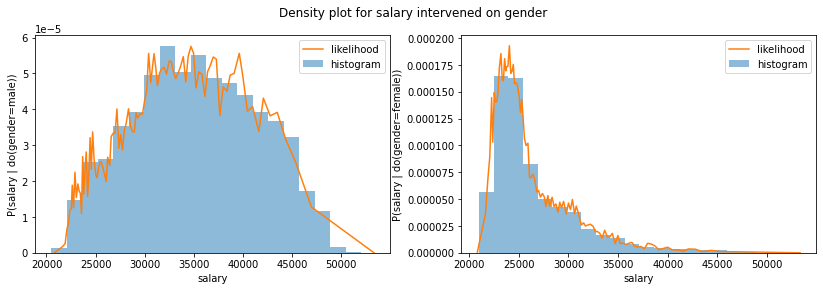

In [25]:
N = 10000
K = 100

fig, axes = plt.subplots(1, 2, figsize=(7 * 2, 4))

for ax, v in zip(axes, [True, False]):
    with torch.no_grad():
        x = graph.sample(N, 'salary', dict(gender=v)).cpu().numpy()
    
    qs = df_train.salary.quantile(np.linspace(0, 1, K)).values # we compute the loglk of values unconditionally
    with torch.no_grad():
        loglk = graph.loglk(dict(salary=qs), target_node='salary', interventions=dict(gender=v), ex_n=1000)
        lk = torch.exp(loglk).cpu().numpy()

    ax.hist(x, bins=20, density=True, alpha=.5, label='histogram')
    ax.plot(qs, lk, label='likelihood')
    ax.legend()
    ax.set_xlabel('salary')
    ax.set_ylabel('P(salary | do(gender=%s))' % ('male' if v else 'female'))

fig.suptitle('Density plot for salary intervened on gender')
plt.savefig('plots/density3.pdf')

## Counterfactual Queries

For counterfactual queries, we focus on individuals for whom we have observed some of their variables, and we want to explore the counterfactual world where some variable is intervened.

We will operate on this space from the perspective of fairness: "what would my salary be had I been a man?"

In [26]:
# Given a woman with average salary, what would her salary have been had she been a man?
with torch.no_grad():
    obs_salary = df_train[~df_train.gender].salary.mean()
    
    cf = graph.counterfactual(
        dict(gender=False, salary=obs_salary), # factual values
        target_node='salary',
        interventions=dict(gender=True),
    ).item()
    
obs_salary, cf

(27101.5057576226, 38894.45703125)

We will also perform counterfactual sampling.

If we ask the same query, but pass ```agg=False``` (defaults to True), the method won't aggregate the counterfactual samples and instead return all the internal information used in the computation of counterfactuals (check the method for more details).
The only two variables we are interested in are the first two, x and w. These are counterfactual samples and their associated weights (non-normalized). If we want to generate counterfactual samples, we need a subsample 
of x using the normalized weights ```softmax(w)```. For this, we will use the ```dcg.sampling.weighted_sampling``` function.

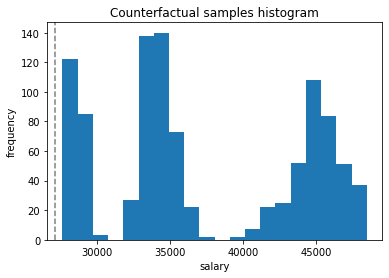

In [27]:
from dcg.sampling import weighted_sampling

with torch.no_grad():
    obs_salary = df_train[~df_train.gender].salary.mean()
    
    x, w, _, _, _ = graph.counterfactual(
        dict(gender=False, salary=obs_salary), # factual values
        target_node='salary',
        interventions=dict(gender=True),
        agg=False,
        ex_n=10000
    )
    
    x = weighted_sampling(1000, x, torch.nn.functional.log_softmax(w, 0))
    # weighted_sampling requires log_w, so use log_softmax to normalize and compute the log
    x = x.cpu().numpy()
    
plt.hist(x, bins=20)
plt.axvline(obs_salary, ls='--', alpha=.5, c='k'); # plot the factual salary
plt.xlabel('salary')
plt.ylabel('frequency')
plt.title('Counterfactual samples histogram')
plt.savefig('plots/cf_sampling_hist1.pdf')

With this plot we can see that there are three subpopulations in the counterfactual salary for this particular combination of factual variables; these probably result from the three possible fields this person might work in. 

Note that with this particular counterfactual distribution, when we simply compute expectations we are omitting this multi-modality; this is why it is important to also consider counterfactual sampling, not just expectations.

Let's finally check our intuition that this multimodality comes as a result of field. If we also measure the field of this woman (set to field 1), we see it affects the counterfactual distribution:

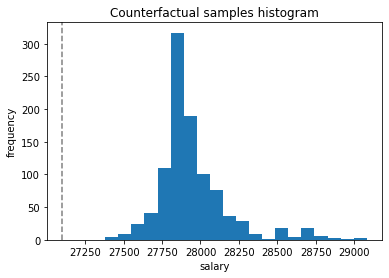

In [28]:
from dcg.sampling import weighted_sampling

with torch.no_grad():
    obs_salary = df_train[~df_train.gender].salary.mean()
    
    x, w, _, _, _ = graph.counterfactual(
        dict(gender=False, salary=obs_salary, field=[[True, False, False]]), # field has 3 levels
        target_node='salary',
        interventions=dict(gender=True),
        agg=False,
        ex_n=10000
    )
    
    x = weighted_sampling(1000, x, torch.nn.functional.log_softmax(w, 0))
    x = x.cpu().numpy()
    
plt.hist(x, bins=20)
plt.axvline(obs_salary, ls='--', alpha=.5, c='k'); # plot the factual salary
plt.xlabel('salary')
plt.ylabel('frequency')
plt.title('Counterfactual samples histogram')
plt.savefig('plots/cf_sampling_hist2.pdf')

Indeed, the multimodality disappears, as the factual field gives us additional information about this individual.